In [15]:
import tensorflow as tf
import pandas as pd
import numpy as np
import lhapdf
import matplotlib.pyplot as plt

import functions


In [21]:
class A0(tf.keras.layers.Layer):
    def __init__(self, kperp2avg=.57, pperp2avg=.12, **kwargs):
        super(A0, self).__init__(name='a0')
        self.m1 = tf.Variable(1., name='m1')
        self.kperp2avg = kperp2avg
        self.pperp2avg = pperp2avg
        self.e = tf.constant(1.)
        
    def get_config(self):
        config = super().get_config().copy()
        
        config.update({
            'kperp2avg': self.kperp2avg,
            'pperp2avg': self.pperp2avg
        })
        
        return config
        
    def call(self, inputs):
        z = inputs[:, 0]
        pht = inputs[:, 1]
        ks2avg = (self.kperp2avg*self.m1**2)/(self.m1**2 + self.kperp2avg) #correct 
        topfirst = (z**2 * self.kperp2avg + self.pperp2avg) * ks2avg**2 #correct
        bottomfirst = (z**2 * ks2avg + self.pperp2avg)**2 * self.kperp2avg #correct
        exptop = pht**2 * z**2 * (ks2avg - self.kperp2avg) #correct
        expbottom = (z**2 * ks2avg + self.pperp2avg) * (z**2 * self.kperp2avg + self.pperp2avg) #correct
        last = tf.sqrt(2*self.e) * z * pht / self.m1 #correct      
        return (topfirst/bottomfirst) * tf.exp(-exptop/expbottom) * last

class Quotient(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Quotient, self).__init__()
    
    def call(self, inputs):
        if len(inputs) != 2 or inputs[0].shape[1] != 1:
            raise Exception('must be two tensors of shape (?, 1)')
        return inputs[0]/inputs[1]    

def h(model, kperp):
    m1 = model.get_layer('a0').m1.numpy()
    e = model.get_layer('a0').e.numpy()
    return np.sqrt(2*e) * (kperp/m1) * np.exp(-kperp**2/m1**2)

    
def nnq(model, x, hadronstr):
    if not hadronstr in ['nnu', 'nnd', 'nns', 'nnubar', 'nndbar', 'nnsbar']:
        raise Exception('hadronstr must be one of nnu, nnd, nns, nnubar, nndbar, nnsbar')
    lilmod = tf.keras.backend.function(model.get_layer('x').input,
                                       model.get_layer(hadronstr).output)
    return lilmod(x)

#import functions_new

def fqp(x, QQ, kperp2avg, kperp, flavor):
    '''
    x and QQ must be iterables of some kind
    '''
    #had = functions_new.Hadron()
    had = functions.Hadron()
    fq = had.pdf(flavor, x, QQ)
    return fq*(1/(np.pi*kperp2avg))*np.exp(-kperp**2/kperp2avg)

def xsivdist(model, x, QQ, kperp2avg, flavor, kperp):
    refDict = {-3: 'nnsbar',
               -2: 'nnubar',
               -1: 'nndbar',
               1: 'nnd',
               2: 'nnu',
               3: 'nns'}
    nnqval = nnq(model, np.array([x]), refDict[flavor])
    hval = h(model, kperp)
    fqpval = fqp([x], [QQ], kperp2avg, kperp, flavor)
    
    #return ((2*nnqval*hval*fqpval)[0, :])*x
    return ((2*nnqval*hval*fqpval)[0, :])


def xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, flavor, kperp):
    results = []
    for i in range(numReplicas):
        t = tf.keras.models.load_model('Models_SIDIS_1000/rep' + str(i) + '.h5', 
                                         custom_objects={'A0': A0, 'Quotient': Quotient})
        results.append(list(xsivdist(t, x, QQ, kperp2avg, flavor, kperp)))
    return np.array(results)


def plotSivDistBands(numReplicas, x, QQ, kperp2avg, flavor, kperp, numSigma=2):
    #datann = DataANN()
    #X, y, err = datann.makeData(df, [hadron], [dependence])

    results = xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, 2, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)

    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='b', alpha=0.3)
    plt.plot(kperp, yhat, 'b', label='$u$')
    
    results = xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, 1, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)
    
    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='r', alpha=0.3)
    plt.plot(kperp, yhat, 'r', label='$d$')
    
    results = xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, 3, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)
    
    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='g', alpha=0.3)
    plt.plot(kperp, yhat, 'g', label='$s$')
    
    #plt.legend()
    #plt.title('Hermes 2009')
    #plt.xlabel('$k_{\perp}$')
    #plt.ylabel('$x\Delta^Nf(x, k_{\perp})$')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylim(-0.06,0.06)
    plt.legend(loc=4,fontsize=20,handlelength=3)
    plt.savefig('SiversQ_SIDIS_NN.pdf', format='pdf', bbox_inches='tight')
    
    
def plotSivDistBandsSea(numReplicas, x, QQ, kperp2avg, flavor, kperp, numSigma=2):
    #datann = DataANN()
    #X, y, err = datann.makeData(df, [hadron], [dependence])

    results = xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, -2, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)

    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='b', alpha=0.3)
    plt.plot(kperp, yhat, 'b', label='$\\bar{u}$')
    
    results = xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, -1, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)
    
    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='r', alpha=0.3)
    plt.plot(kperp, yhat, 'r', label='$\\bar{d}$')
    
    results = xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, -3, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)
    
    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='g', alpha=0.3)
    plt.plot(kperp, yhat, 'g', label='$\\bar{s}$')
    
#     plt.legend()
#     plt.title('Hermes 2009')
#     plt.xlabel('$k_{\perp}$')
#     plt.ylabel('$x\Delta^Nf(x, k_{\perp})$')
#     plt.savefig('2009HermesUDSsea.pdf', format='pdf', bbox_inches='tight')
    #plt.figure(figsize=(15,10))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylim(-0.006,0.01)
    plt.legend(loc=4,fontsize=20,handlelength=3)
    plt.savefig('SiversAntiQ_SIDIS_NN.pdf', format='pdf', bbox_inches='tight')    

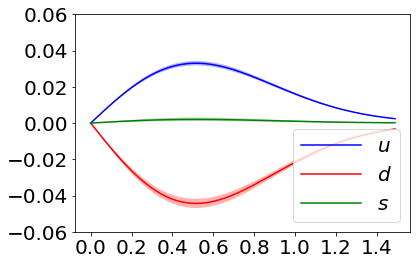

In [19]:
plotSivDistBands(5, .1, 2.4, .57, -2, np.array(list(range(150)))/100)

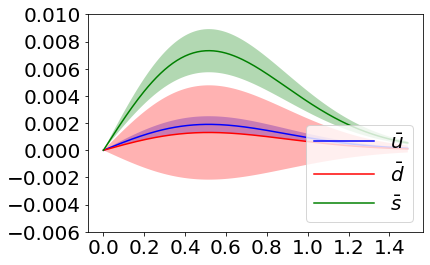

In [22]:
plotSivDistBandsSea(5, .1, 2.4, .57, -2, np.array(list(range(150)))/100)